<a href="https://colab.research.google.com/github/aryamandevv/MachineLearning/blob/master/asd9884_lab_gene_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [3]:
# TODO 1
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls",index_col=0)

In [4]:
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


In [5]:
df.tail()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
J3295_11,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,1.057971,...,0.183324,0.374088,0.318782,0.204660,0.328327,1.364823,Ts65Dn,Saline,S/C,t-SC-s
J3295_12,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,1.081150,...,0.175674,0.375259,0.325639,0.200415,0.293435,1.364478,Ts65Dn,Saline,S/C,t-SC-s
J3295_13,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,0.884342,...,0.158296,0.422121,0.321306,0.229193,0.355213,1.430825,Ts65Dn,Saline,S/C,t-SC-s
J3295_14,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,0.922595,...,0.196296,0.397676,0.335936,0.251317,0.365353,1.404031,Ts65Dn,Saline,S/C,t-SC-s
J3295_15,0.302626,0.461059,0.256564,2.092790,2.594348,0.251001,0.191811,2.361816,0.223632,1.064085,...,0.187556,0.420347,0.335062,0.252995,0.365278,1.370999,Ts65Dn,Saline,S/C,t-SC-s


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [6]:
# TODO 2
df1 = df.copy()

for col in df1.columns:
  if pd.api.types.is_numeric_dtype(df1[col]):
    df1[col] = df1[col].fillna(df1[col].mean())
  else:
    # For non-numeric columns, we'll use the mode (most frequent value)
    df1[col] = df1[col].fillna(df1[col].mode()[0])

## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [8]:
# TODO 3
unique_genotypes, y = np.unique(df1['Genotype'].values, return_inverse=True)

print("Unique Genotypes: ", unique_genotypes)
print("Numeric Labels: ", y)

Unique Genotypes:  ['Control' 'Ts65Dn']
Numeric Labels:  [0 0 0 ... 1 1 1]


In [9]:
# Binary Classification (0, 1)
if len(unique_genotypes) != 2:
  raise Exception("Expected 2 unique genotypes for binary classification, but found", len(unique_genotypes))

In [13]:
# Map the genotypes to 0 and 1
genotype_map = {unique_genotypes[0]: 0, unique_genotypes[1]: 1}
y = np.array([genotype_map[genotype] for genotype in df1['Genotype'].values])
label_meaning = {0: "One Genotype (Non-Down's Syndrome)",
                 1: "Other Genotype (Down's Syndrome)"}

print("Binary labels:", y)
print("Label meanings:")
for label, meaning in label_meaning.items():
    print(f"{label}: {meaning}")

print("\nGenotype Mappings:")
for genotype, label in genotype_map.items():
    print(f"{genotype}: {label} - {label_meaning[label]}")

Binary labels: [0 0 0 ... 1 1 1]
Label meanings:
0: One Genotype (Non-Down's Syndrome)
1: Other Genotype (Down's Syndrome)

Genotype Mappings:
Control: 0 - One Genotype (Non-Down's Syndrome)
Ts65Dn: 1 - Other Genotype (Down's Syndrome)


As predictors, get all but the last four columns of the dataframes.  Store the data matrix into `X` and the names of the columns in `xnames`.

In [15]:
# TODO 4
X = df1.iloc[:, :-4]
xnames = X.columns.tolist()
X = X.values

print("Shape of X:", X.shape)
print("Number of predictors:", len(xnames))
print("Predictor names:", xnames)

Shape of X: (1080, 77)
Number of predictors: 77
Predictor names: ['DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N', 'pBRAF_N', 'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N', 'PKCA_N', 'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N', 'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N', 'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N', 'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N', 'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N', 'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N', 'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N', 'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BAD_N', 'BCL2_N', 'pS6_N', 'pCFOS_N', 'SYP_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N', 'CaNA_N']


Split the data into training and test with 30% allocated for test.  You can use the train

In [16]:
from sklearn.model_selection import train_test_split

#Use : shuffle=True, random_state=3 so we all can have same split.
# TODO 5:
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=3)

In [17]:
print("Training set shape:", Xtr.shape)
print("Test set shape:", Xts.shape)
print("Training labels shape:", ytr.shape)
print("Test labels shape:", yts.shape)

Training set shape: (756, 77)
Test set shape: (324, 77)
Training labels shape: (756,)
Test labels shape: (324,)


Scale the data with the `StandardScaler`.  Store the scaled values in `Xtr1` and `Xts1`.

In [24]:
from sklearn.preprocessing import StandardScaler

# TODO 6
scalar = StandardScaler()
Xtr1 = scalar.fit_transform(Xtr)
Xts1 = scalar.transform(Xts)

print("Scaled training data shape:", Xtr1.shape)
print("Scaled test data shape:", Xts1.shape)

Scaled training data shape: (756, 77)
Scaled test data shape: (324, 77)


In [28]:
print("\nMean of scaled training data:")
print(np.round(Xtr1.mean(axis=0)[:5], 2)) # 2 decimal places
print(Xtr1.std(axis=0)[:5])

print("\nStandard deviation of scaled training data:")
print(np.round(Xtr1.std(axis=0)[:5], 2))


Mean of scaled training data:
[-0. -0.  0.  0. -0.]
[1. 1. 1. 1. 1.]

Standard deviation of scaled training data:
[1. 1. 1. 1. 1.]


In [29]:
print([f'{x:.2f}' for x in Xtr1.mean(axis=0)[:5]])
print([f'{x:.2f}' for x in Xtr1.std(axis=0)[:5]])

['-0.00', '-0.00', '0.00', '0.00', '-0.00']
['1.00', '1.00', '1.00', '1.00', '1.00']


Create a `LogisticRegression` object `logreg` and `fit` on the scaled training data.  Set the regularization level to `C=1e5` and use the optimizer `solver=liblinear`.

In [30]:
# TODO 7
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='liblinear', random_state=3)
logreg.fit(Xtr1, ytr)

LogisticRegression(C=100000.0, random_state=3, solver='liblinear')

In [38]:
print("Model fitted successfully!")
print("Number of iterations:", logreg.n_iter_)
print(f"Intercept: {logreg.intercept_[0]:.2f}")
print("Number of features:", len(logreg.coef_[0]))

Model fitted successfully!
Number of iterations: [12]
Intercept: 2.37
Number of features: 77


Measure the accuracy of the classifer on test data.  You should get around 94%.  

In [39]:
# TODO 8
yhat = logreg.predict(Xts1)
accuracy = np.mean(yhat == yts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.06%


In [40]:
test_accuracy = logreg.score(Xts1, yts)

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test accuracy percentage: {test_accuracy * 100:.2f}%")

Test accuracy: 0.9506
Test accuracy percentage: 95.06%


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = logreg.predict(Xts1)

print("\nConfusion Matrix:")
print(confusion_matrix(yts, y_pred))
print("\nClassification Report:")
print(classification_report(yts, y_pred))


Confusion Matrix:
[[166  10]
 [  6 142]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       176
           1       0.93      0.96      0.95       148

    accuracy                           0.95       324
   macro avg       0.95      0.95      0.95       324
weighted avg       0.95      0.95      0.95       324



## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  Jse the `plt.stem()` function with the `use_line_collection=True` option.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

<ipython-input-44-8856a42f85a1>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(W, use_line_collection=True)


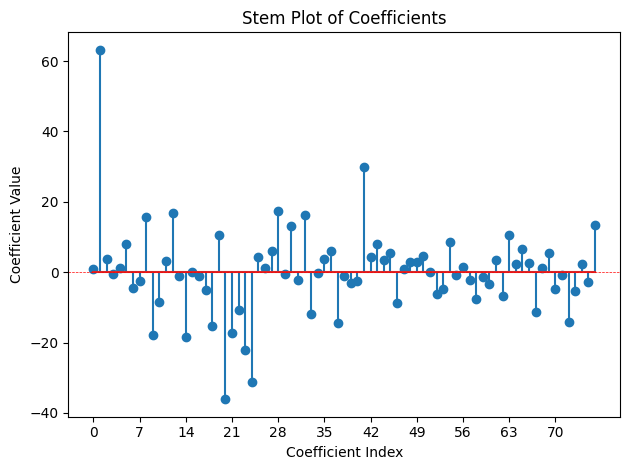

In [44]:
# TODO 9
W = logreg.coef_[0]
plt.stem(W, use_line_collection=True)
plt.xlabel("Coefficient Index")
plt.ylabel("Coefficient Value")
plt.title("Stem Plot of Coefficients")

plt.axhline(y=0, color='r', linestyle='--', linewidth=0.5)

# Optionally, add feature names if they're not too many
if len(xnames) <= 20:
    plt.xticks(range(len(W)), xnames, rotation=45, ha='right')
else:
    plt.xticks(range(0, len(W), len(W)//10))  # Show only every 10th feature index

plt.tight_layout()
plt.show()

In [45]:
# Print the top 5 positive and negative coefficients
top_positive = sorted(zip(xnames, W), key=lambda x: x[1], reverse=True)[:5]
top_negative = sorted(zip(xnames, W), key=lambda x: x[1])[:5]

print("Top 5 positive coefficients:")
for name, coef in top_positive:
    print(f"{name}: {coef:.4f}")

print("\nTop 5 negative coefficients:")
for name, coef in top_negative:
    print(f"{name}: {coef:.4f}")

Top 5 positive coefficients:
ITSN1_N: 63.2109
TIAM1_N: 29.8079
TRKA_N: 17.2856
PKCA_N: 16.7620
SOD1_N: 16.3482

Top 5 negative coefficients:
BRAF_N: -36.1191
ERK_N: -31.2983
ELK_N: -21.9868
pNR1_N: -18.4676
pELK_N: -17.9252


You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.   Below we will use L1 regression to enforce sparsity.  Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [46]:
# TODO 10
# list of (feature name, coefficient) tuples
feature_coefficients = list(zip(xnames, W))

# Sort the list by the absolute value of the coefficients in descending order
sorted_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

print("The two genes most likely to be involved in Down's Syndrome:")
for name, coef in sorted_coefficients[:2]:
    print(f"Gene: {name}, Coefficient: {coef:.4f}")

The two genes most likely to be involved in Down's Syndrome:
Gene: ITSN1_N, Coefficient: 63.2109
Gene: BRAF_N, Coefficient: -36.1191


## Cross Validation

To obtain a slightly more accurate result, now perform 10-fold cross validation and measure the average precision, recall and f1-score.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

nfold = 10
kf = KFold(n_splits=nfold,shuffle=True, random_state=42)

# TODO 11
precisions, recalls, f1_scores, error_rates = [], [], [], []

# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    logreg = LogisticRegression(C=1e5, solver='liblinear')
    logreg.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = logreg.predict(X_test_scaled)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    error_rate = 1 - accuracy_score(y_test, y_pred)

    # Store the metrics
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    error_rates.append(error_rate)

    print(f"Fold {fold}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1-score = {f1:.4f}, Error Rate = {error_rate:.4f}")

Fold 1: Precision = 0.9464, Recall = 0.9464, F1-score = 0.9464, Error Rate = 0.0556
Fold 2: Precision = 0.9500, Recall = 0.9268, F1-score = 0.9383, Error Rate = 0.0463
Fold 3: Precision = 0.9773, Recall = 0.9556, F1-score = 0.9663, Error Rate = 0.0278
Fold 4: Precision = 0.9245, Recall = 0.9423, F1-score = 0.9333, Error Rate = 0.0648
Fold 5: Precision = 0.8980, Recall = 1.0000, F1-score = 0.9462, Error Rate = 0.0463
Fold 6: Precision = 0.9400, Recall = 0.9792, F1-score = 0.9592, Error Rate = 0.0370
Fold 7: Precision = 0.9455, Recall = 0.9630, F1-score = 0.9541, Error Rate = 0.0463
Fold 8: Precision = 0.9483, Recall = 0.9322, F1-score = 0.9402, Error Rate = 0.0648
Fold 9: Precision = 0.9677, Recall = 0.9375, F1-score = 0.9524, Error Rate = 0.0556
Fold 10: Precision = 0.9388, Recall = 0.9787, F1-score = 0.9583, Error Rate = 0.0370


In [51]:
# Calculate and print mean metrics
print("\nMean Metrics across all folds:")
print(f"Precision: {np.mean(precisions):.4f} (+/- {np.std(precisions):.4f})")
print(f"Recall: {np.mean(recalls):.4f} (+/- {np.std(recalls):.4f})")
print(f"F1-score: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})")
print(f"Error Rate: {np.mean(error_rates):.4f} (+/- {np.std(error_rates):.4f})")


Mean Metrics across all folds:
Precision: 0.9436 (+/- 0.0207)
Recall: 0.9562 (+/- 0.0225)
F1-score: 0.9495 (+/- 0.0099)
Error Rate: 0.0481 (+/- 0.0116)


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7.

In [55]:
# TODO 12
y = df1['class'].values
unique_classes, y = np.unique(df1['class'].values, return_inverse=True)

print("Unique Classes: ", unique_classes)
print("Numeric Labels: ", y)
print("Number of unique classes:", len(unique_classes))
print("Shape of y:", y.shape)
print("Unique values in y:", np.unique(y))

print("\nSample of the conversion:")
for i in range(min(10, len(y))):  # Print first 10 or less
    print(f"Original: {y[i]}, Numeric: {y[i]}")

Unique Classes:  ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']
Numeric Labels:  [0 0 0 ... 7 7 7]
Number of unique classes: 8
Shape of y: (1080,)
Unique values in y: [0 1 2 3 4 5 6 7]

Sample of the conversion:
Original: 0, Numeric: 0
Original: 0, Numeric: 0
Original: 0, Numeric: 0
Original: 0, Numeric: 0
Original: 0, Numeric: 0
Original: 0, Numeric: 0
Original: 0, Numeric: 0
Original: 0, Numeric: 0
Original: 0, Numeric: 0
Original: 0, Numeric: 0


Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method.

Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test accuracy across the folds.

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# TODO 13
# Initialize variables
confusion_matrices = np.zeros((8, 8))  # 8x8 for 8 classes
accuracies = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit logistic regression model
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    logreg.fit(X_train_scaled, y_train)

    # Predict and evaluate
    y_pred = logreg.predict(X_test_scaled)

    # Compute confusion matrix and add to total
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices += cm

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Normalize confusion matrix
C = confusion_matrices / confusion_matrices.sum(axis=1, keepdims=True)

# Print normalized confusion matrix
print("Normalized Confusion Matrix:")
print(np.array_str(C, precision=4, suppress_small=True))

# Calculate and print mean and SE of test accuracy
mean_accuracy = np.mean(accuracies)
se_accuracy = np.std(accuracies) / np.sqrt(nfold)

print(f"\nMean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Error of Test Accuracy: {se_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Normalized Confusion Matrix:
[[0.9867 0.0067 0.     0.     0.0067 0.     0.     0.    ]
 [0.0074 0.9778 0.     0.     0.0074 0.0074 0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.0148 0.     0.     0.9778 0.     0.     0.     0.0074]
 [0.     0.0074 0.     0.     0.9926 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]

Mean Test Accuracy: 0.9917
Standard Error of Test Accuracy: 0.0024


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
<ipython-input-57-c8c6bbefdf4f>:24: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(W.shape[1]), W[0, :], use_line_collection=True)


Shape of weight matrix: (8, 77)


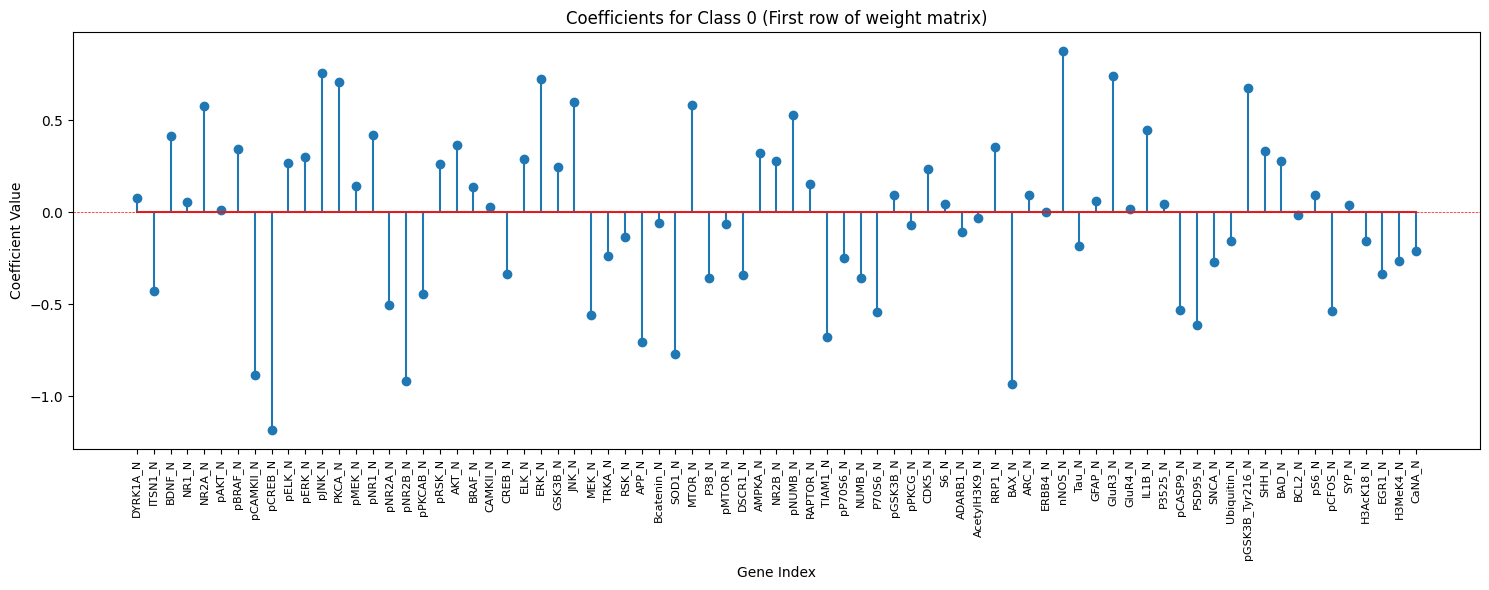


Top 5 positive coefficients for Class 0:
nNOS_N: 0.8767
pJNK_N: 0.7600
GluR3_N: 0.7407
ERK_N: 0.7233
PKCA_N: 0.7084

Top 5 negative coefficients for Class 0:
pCREB_N: -1.1859
BAX_N: -0.9337
pNR2B_N: -0.9159
pCAMKII_N: -0.8863
SOD1_N: -0.7720


In [57]:
# TODO 14
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Assuming X and y are already defined

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression model on the entire dataset
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logreg.fit(X_scaled, y)

# Get the weight coefficients
W = logreg.coef_  # This should be an 8 x 77 matrix

print("Shape of weight matrix:", W.shape)

# Create a stem plot of the first row of the weight matrix
plt.figure(figsize=(15, 6))
plt.stem(range(W.shape[1]), W[0, :], use_line_collection=True)
plt.title('Coefficients for Class 0 (First row of weight matrix)')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient Value')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.5)

# If you have gene names, you can use them for x-axis labels
if len(xnames) == W.shape[1]:
    plt.xticks(range(W.shape[1]), xnames, rotation=90, ha='center', fontsize=8)
else:
    plt.xticks(range(0, W.shape[1], 5))  # Show every 5th index if no gene names

plt.tight_layout()
plt.show()

# Print the top 5 positive and negative coefficients for the first class
coeffs_with_names = list(zip(xnames, W[0, :]))
top_positive = sorted(coeffs_with_names, key=lambda x: x[1], reverse=True)[:5]
top_negative = sorted(coeffs_with_names, key=lambda x: x[1])[:5]

print("\nTop 5 positive coefficients for Class 0:")
for name, coef in top_positive:
    print(f"{name}: {coef:.4f}")

print("\nTop 5 negative coefficients for Class 0:")
for name, coef in top_negative:
    print(f"{name}: {coef:.4f}")

## L1-Regularization

This section is bonus.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [housing demo](../unit05_lasso/demo2_housing.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation
* You should select around 20 values of `C`.  It is up to you find a good range.
* Make appropriate plots and print out to display your results
* How does the accuracy compare to the accuracy achieved without regularization.

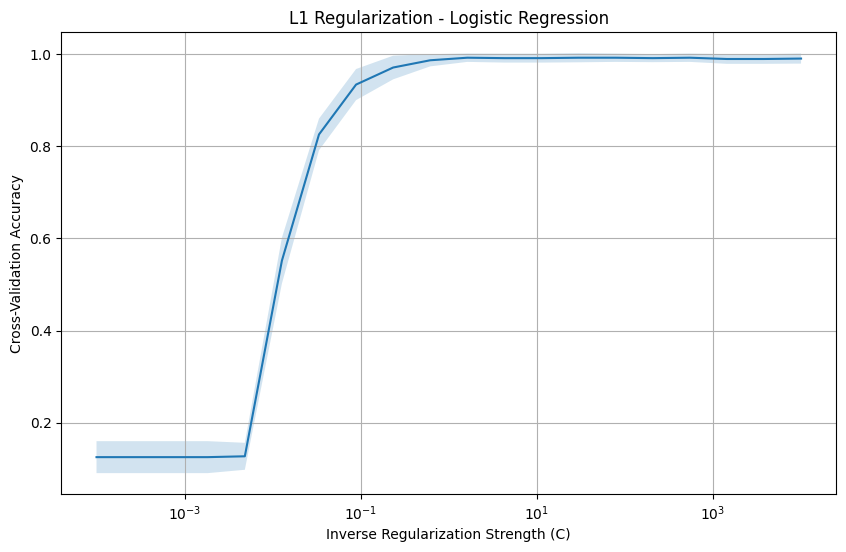

In [60]:
# TODO 15
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a range of C values (inverse regularization strength)
C_values = np.logspace(-4, 4, 20)

# Perform 10-fold cross-validation for each C value
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mean_scores = []
std_scores = []

for C in C_values:
    logreg = OneVsRestClassifier(LogisticRegression(penalty='l1', C=C, solver='liblinear'))
    scores = cross_val_score(logreg, X_scaled, y, cv=kf, scoring='accuracy')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# Plot the cross-validation results
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, mean_scores)
plt.fill_between(C_values, np.array(mean_scores) - np.array(std_scores),
                 np.array(mean_scores) + np.array(std_scores), alpha=0.2)
plt.xlabel('Inverse Regularization Strength (C)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('L1 Regularization - Logistic Regression')
plt.grid(True)
plt.show()

In [61]:
# Find the best C value
best_C = C_values[np.argmax(mean_scores)]
print(f"Best C value: {best_C:.4f}")
print(f"Best mean cross-validation accuracy: {max(mean_scores):.4f}")

# Train the model with the best C value
best_logreg = OneVsRestClassifier(LogisticRegression(penalty='l1', C=best_C, solver='liblinear'))
best_logreg.fit(X_scaled, y)

# Count non-zero coefficients (selected features)
n_selected_features = np.sum(best_logreg.estimators_[0].coef_ != 0)
print(f"Number of selected features: {n_selected_features}")

Best C value: 1.6238
Best mean cross-validation accuracy: 0.9926
Number of selected features: 44


Unregularized model mean accuracy: 0.9852
Unregularized model std accuracy: 0.0119


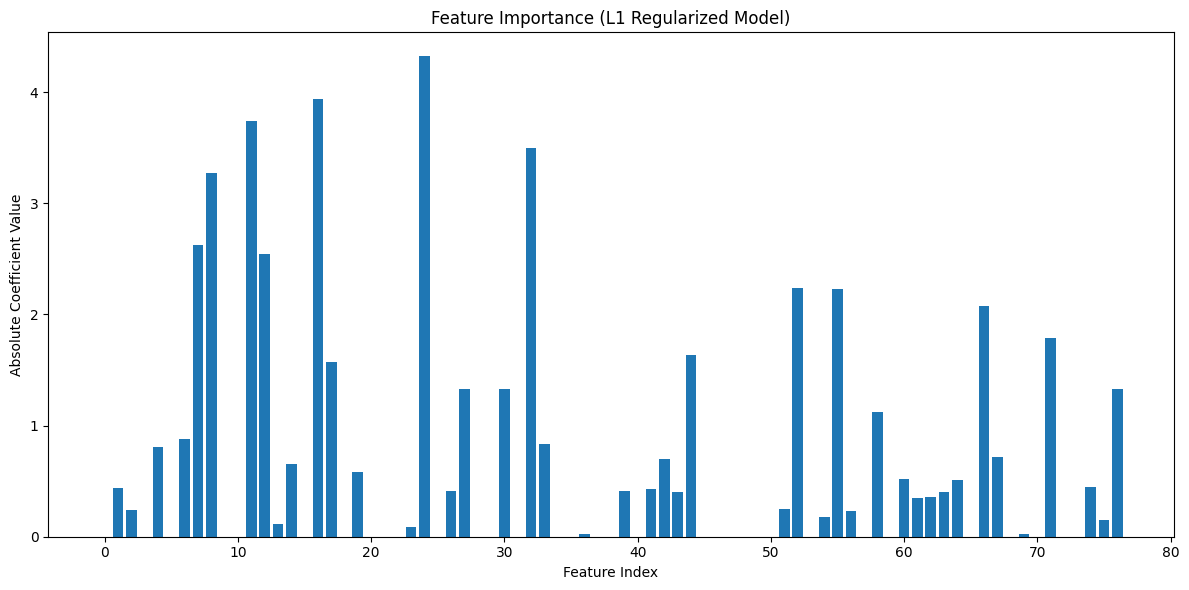

In [63]:
# Compare with unregularized model
unregularized_logreg = OneVsRestClassifier(LogisticRegression(penalty=None, solver='lbfgs'))
unregularized_scores = cross_val_score(unregularized_logreg, X_scaled, y, cv=kf, scoring='accuracy')
print(f"Unregularized model mean accuracy: {unregularized_scores.mean():.4f}")
print(f"Unregularized model std accuracy: {unregularized_scores.std():.4f}")

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), np.abs(best_logreg.estimators_[0].coef_[0]))
plt.xlabel('Feature Index')
plt.ylabel('Absolute Coefficient Value')
plt.title('Feature Importance (L1 Regularized Model)')
plt.tight_layout()
plt.show()